In [103]:
import cplex as cp
import numpy as np
import my_graph

def column_generation(d, V, E, Cap_E, Pd0):
    """
    使用列生成算法求解切Path Generation问题
    d: demand, (sd, td) ; e.g. (A, E) (A和E之间必须联通)
    V : vertices
    E : edges
    Cap_E : Maximum capacity of each edge
    """

    sd = d[0]
    td = d[1]

    # 初始化主问题 (RLPM)
    cplex_obj = cp.Cplex()
    cplex_obj.set_results_stream(None)  # 禁用输出流，保持控制台整洁
    cplex_obj.objective.set_sense(cplex_obj.objective.sense.maximize)

    # 初始化模式矩阵 Pd（每列是一种路径）
    num_items = Pd0.shape[1]
    num_dual_items = len(E)
    Pd = Pd0

    variable_names = [f"xp{i + 1}" for i in range(num_items)]

    # 添加初始变量到主问题
    for i in range(num_items):
        cplex_obj.variables.add(names=[variable_names[i]], types=['C'], lb=[0])

    # 以Pd为系数，添加约束
    for i, row in enumerate(Pd):
        cplex_obj.linear_constraints.add(
            lin_expr=[cp.SparsePair(ind=variable_names, val=row.tolist())],
            senses=["L"],  # "L" 表示小于等于 (<=)
            rhs=[Cap_E[i]],
            names = [f"st{i + 1}"]
        )

    # 创建主问题
    cplex_obj.objective.set_linear([(variable_names[i], 1.0) for i in range(num_items)])

    iter = 0
    while True:
        iter += 1
        # 求解主问题 (RLPM)
        cplex_obj.solve()
        xp = cplex_obj.solution.get_values()
        obj_fct_val = np.sum(xp)
        print("==================iter [", iter, "]======================")
        print("xp = ", xp)
        print("obj_fct_val = ", obj_fct_val)

        # 显式构建对偶问题
        cplex_obj_dual = cp.Cplex()
        cplex_obj_dual.set_results_stream(None)
        cplex_obj_dual.objective.set_sense(cplex_obj_dual.objective.sense.minimize)

        # 对偶问题目标函数：min c1*pi1 + c2*pi2 + ... + ce*pie
        dual_var_names = [f"pi{i + 1}" for i in range(num_dual_items)]
        cplex_obj_dual.variables.add(
            names=dual_var_names,
            obj=Cap_E, # 定义变量的目标函数系数
            types=['C'] * num_dual_items,
            lb=[1e-6] * num_dual_items,
            # ub=[1] * num_dual_items  # pi <= 1, 把pi缩放到[0, 1]范围内，因为我们希望pi可以表示一个概率、一种权重
        )

        # 对偶问题的约束： A^T * pi >= 1， A=Pd
        for j in range(Pd.shape[1]):
            constraint = [[dual_var_names, Pd[:, j].tolist()]]
            cplex_obj_dual.linear_constraints.add(
                lin_expr=constraint,
                senses=['G'],
                rhs=[1.0]  # 对应主问题目标函数的系数为1
            )

        # 求解对偶问题
        cplex_obj_dual.solve()

        # 获取对偶解 pi
        pi = np.array(cplex_obj_dual.solution.get_values())

        # 初始化辅助子问题 (Auxiliary Problem)
        V_aux = [u for u in V]
        # E_aux = [(u, v, pi[i]) for i, (u, v) in enumerate(E)]
        E_aux = [(u, v, max(pi[i], 1e-6)) for i, (u, v) in enumerate(E)]
        graph_aux = my_graph.Graph.graph_constructor(V_aux, E_aux)
        g_aux_obj = my_graph.Graph(graph_aux)
        # _, _, p_new = g_aux_obj.dijkstra_with_end_vertex(sd, td)
        #
        # p_new_binary = [1 if pair in p_new else 0 for pair in E]

        path, distance, path_paired = g_aux_obj.dijkstra_with_end_vertex(sd, td)  # 从辅助问题求解路径
        # print("Path paired from auxiliary problem:", path_paired)

        # 生成二进制表示
        p_new_binary = [1 if pair in path_paired else 0 for pair in E]
        # print("p_new_binary:", p_new_binary)

        reduced_cost = 1 - np.dot(pi, p_new_binary)


        print_result(iter,
                     cplex_obj,
                     obj_fct_val,
                     xp,
                     pi,
                     p_new_binary,
                     reduced_cost)

        visualize_process_with_legend(V, E, Cap_E, Pd, xp)

        # 如果 reduced cost < 0，停止迭代
        if reduced_cost < 0.0001:
            break

        # 将新模式添加到模式矩阵 A=Pd
        Pd = np.column_stack((Pd, p_new_binary))
        print(Pd)

        # 在主问题中添加新变量
        new_var_name = f"xp{Pd.shape[1]}"
        cplex_obj.variables.add(names=[new_var_name], types=['C'], lb=[0], ub=[cp.infinity])

        # 更新目标函数
        cplex_obj.objective.set_linear([(new_var_name, 1.0)])

        # 修改约束，将新变量添加到所有边的容量约束中
        for i in range(len(E)):  # 遍历所有边（约束行）
            coefficient = p_new_binary[i]  # 新路径对应当前边的二进制值
            if coefficient != 0:  # 只有当系数非零时才需要更新约束
                cplex_obj.linear_constraints.set_coefficients(i, new_var_name, coefficient)



    # 获取最终解
    final_solution = cplex_obj.solution.get_values()

    # 对 x 向下取整
    final_solution = np.floor(final_solution)

    # 计算最终目标值
    final_obj_value = np.sum(final_solution)

    return Pd, final_solution, final_obj_value

In [125]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.patches import FancyArrowPatch, Patch

def visualize_process_with_legend(V, E, capacity, Pd, xp):
    # Create a directed graph
    G = nx.DiGraph()
    G.add_nodes_from(V)

    # Add edges to the graph
    for i, edge in enumerate(E):
        u, v = edge
        G.add_edge(u, v, capacity=capacity[i])

    # Position nodes using a layout
    pos = nx.spring_layout(G, seed=42)

    # Compute flow values for each path (columns of Pd)
    flows_per_edge = Pd * xp  # Each column represents the flow of a path
    total_flow = np.sum(flows_per_edge, axis=1)  # Sum flow contributions across all paths
    final_obj_value = sum(total_flow)  # Total flow or objective value

    # Update the graph with total flow values
    for i, edge in enumerate(E):
        G[edge[0]][edge[1]]['flow'] = total_flow[i]

    # Define distinct colors for paths
    num_paths = Pd.shape[1]
    cmap = plt.get_cmap("tab10")
    path_colors = [cmap(i) for i in range(num_paths)]

    # Plot the base graph (nodes only)
    plt.figure(figsize=(10, 7))
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=700,
        node_color='lightgreen',
        font_size=12,
        font_weight='bold',
    )


    # Draw edges with multiple colors using FancyArrowPatch
    ax = plt.gca()
    for i, (u, v) in enumerate(E):
        if G.has_edge(u, v):
            # Get edge position
            x_start, y_start = pos[u]
            x_end, y_end = pos[v]
            dx, dy = x_end - x_start, y_end - y_start

            print("！！！！！！！！！！！！：", num_paths)
            # Draw multiple bands for each edge
            for path_idx in range(num_paths):
                print(f"xp[{path_idx}]: ", xp[path_idx])
                if xp[path_idx] == 0:
                   if Pd[i, path_idx] > 0:
                      color = path_colors[path_idx]
                      offset = 0.05 * (path_idx - num_paths / 2)  # Offset for each path
                      curve_rad = 0.2 + 0.05 * path_idx  # Adjust curvature for separation
                      arrow = FancyArrowPatch(
                          (x_start, y_start),
                          (x_end, y_end),
                          connectionstyle=f"arc3,rad={curve_rad}",
                          arrowstyle="-|>",
                          linewidth=3,  # Arrow width
                          linestyle=(0, (5, 2)),  # Dashed line: (0, (dash_length, gap_length))
                          color=color,
                          alpha=0.8,
                          mutation_scale=15,  # Arrowhead size
                          zorder=2
                      )
                      ax.add_patch(arrow)
                      continue

                if Pd[i, path_idx] > 0 :  # Only draw for non-zero flow
                    color = path_colors[path_idx]
                    offset = 0.05 * (path_idx - num_paths / 2)  # Offset for each path
                    curve_rad = 0.2 + 0.05 * path_idx  # Adjust curvature for separation
                    arrow = FancyArrowPatch(
                        (x_start, y_start),
                        (x_end, y_end),
                        connectionstyle=f"arc3,rad={curve_rad}",
                        arrowstyle="-|>",
                        linewidth=3,  # Arrow width
                        color=color,
                        alpha=0.8,
                        mutation_scale=15,  # Arrowhead size
                        zorder=2
                    )
                    ax.add_patch(arrow)




    # Add flow/capacity labels to edges
    edge_labels = {
        (u, v): f"{G[u][v]['flow']:.2f}/{G[u][v]['capacity']}"
        for u, v in G.edges()
    }
    nx.draw_networkx_edge_labels(
        G,
        pos,
        edge_labels=edge_labels,
        font_color="black",
        font_size=10,
    )

    # Create legend for paths
    legend_handles = [
        Patch(color=path_colors[path_idx], label=f"Path {path_idx + 1}: Flow {xp[path_idx]:.2f}")
        for path_idx in range(num_paths)
    ]
    plt.legend(
        handles=legend_handles,
        loc='upper left',
        bbox_to_anchor=(1.05, 1),
        title="Path Flows",
        fontsize=10,
    )

    plt.title(f"Flow Network (Objective Value: {np.sum(xp):.2f})", fontsize=14)
    plt.tight_layout()
    plt.show()


==================iter [ 1 ]======================
xp =  [5.0]
obj_fct_val =  5.0
[N.1 RLPM problem] :
['xp1']
max xp1
st1 : xp1*1.0 <= 10.0
st2 :  <= 15.0
st3 : xp1*1.0 <= 5.0
st4 :  <= 20.0
st5 :  <= 10.0
st6 : xp1*1.0 <= 10.0
st7 :  <= 25.0
-----------------------------------------------
xp =  [5.0]
max(xp1) =  5.0
-----------------------------------------------
pi =  [1.00000e-06 1.00000e-06 9.99998e-01 1.00000e-06 1.00000e-06 1.00000e-06
 1.00000e-06]
p_new_binary =  [0, 1, 0, 0, 0, 1, 0]
reduced cost = 1 - <pi, p_new> =  0.999998
！！！！！！！！！！！！： 1
xp[0]:  5.0
！！！！！！！！！！！！： 1
xp[0]:  5.0
！！！！！！！！！！！！： 1
xp[0]:  5.0
！！！！！！！！！！！！： 1
xp[0]:  5.0
！！！！！！！！！！！！： 1
xp[0]:  5.0
！！！！！！！！！！！！： 1
xp[0]:  5.0
！！！！！！！！！！！！： 1
xp[0]:  5.0


<ipython-input-125-a3386b71d383>:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


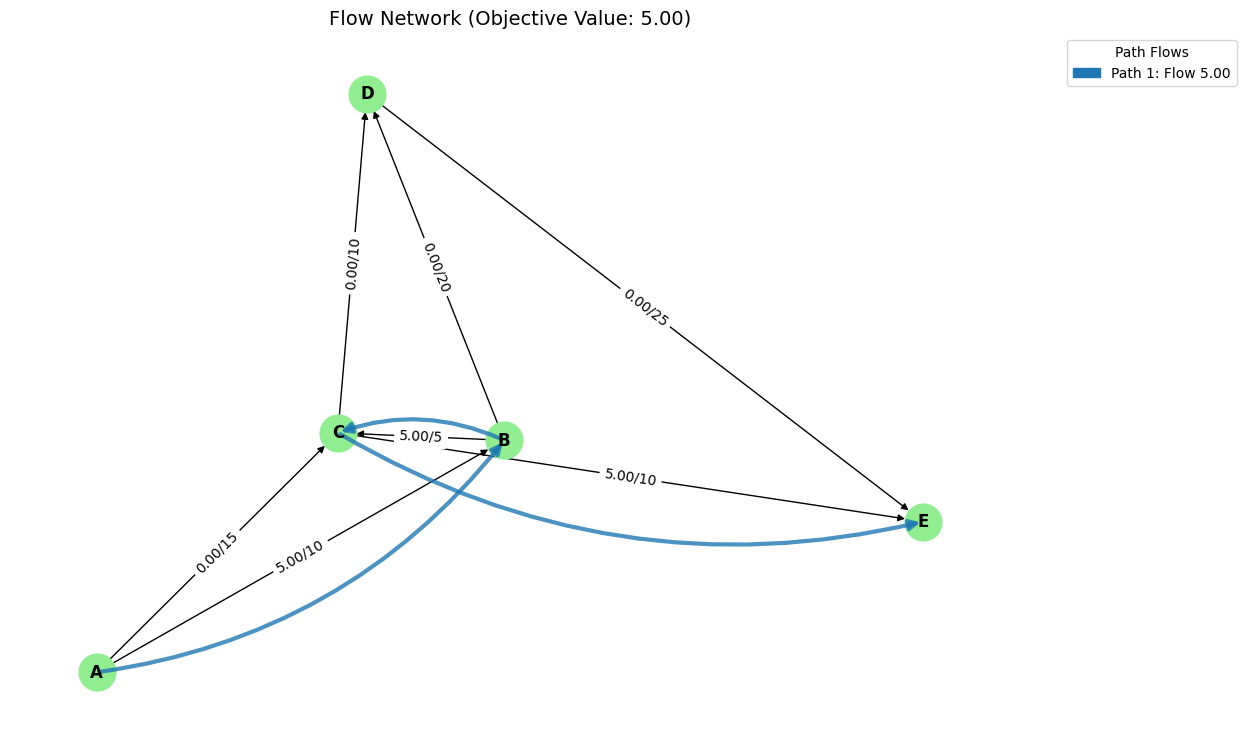

[[1 0]
 [0 1]
 [1 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]]
==================iter [ 2 ]======================
xp =  [0.0, 10.0]
obj_fct_val =  10.0
[N.2 RLPM problem] :
['xp1', 'xp2']
max xp1 + xp2
st1 : xp1*1.0 <= 10.0
st2 : xp2*1.0 <= 15.0
st3 : xp1*1.0 <= 5.0
st4 :  <= 20.0
st5 :  <= 10.0
st6 : xp1*1.0 + xp2*1.0 <= 10.0
st7 :  <= 25.0
-----------------------------------------------
xp =  [0.0, 10.0]
max(xp1 + xp2) =  10.0
-----------------------------------------------
pi =  [1.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06 9.99999e-01
 1.00000e-06]
p_new_binary =  [1, 0, 0, 1, 0, 0, 1]
reduced cost = 1 - <pi, p_new> =  0.999997
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0
！！！！！！！！！！！！： 2
xp[0]:  0.0
xp[1]:  10.0


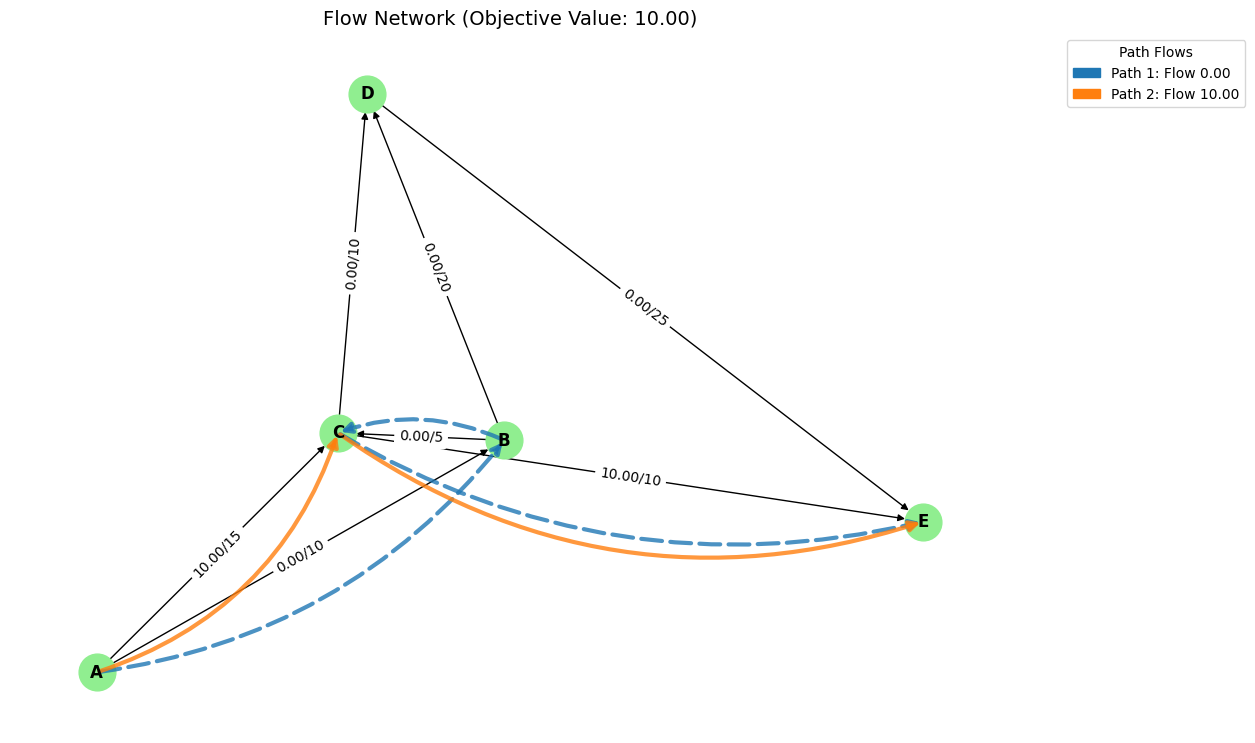

[[1 0 1]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 0 0]
 [1 1 0]
 [0 0 1]]
==================iter [ 3 ]======================
xp =  [0.0, 10.0, 10.0]
obj_fct_val =  20.0
[N.3 RLPM problem] :
['xp1', 'xp2', 'xp3']
max xp1 + xp2 + xp3
st1 : xp1*1.0 + xp3*1.0 <= 10.0
st2 : xp2*1.0 <= 15.0
st3 : xp1*1.0 <= 5.0
st4 : xp3*1.0 <= 20.0
st5 :  <= 10.0
st6 : xp1*1.0 + xp2*1.0 <= 10.0
st7 : xp3*1.0 <= 25.0
-----------------------------------------------
xp =  [0.0, 10.0, 10.0]
max(xp1 + xp2 + xp3) =  20.0
-----------------------------------------------
pi =  [9.99998e-01 1.00000e-06 1.00000e-06 1.00000e-06 1.00000e-06 9.99999e-01
 1.00000e-06]
p_new_binary =  [0, 1, 0, 0, 1, 0, 1]
reduced cost = 1 - <pi, p_new> =  0.999997
！！！！！！！！！！！！： 3
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
！！！！！！！！！！！！： 3
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
！！！！！！！！！！！！： 3
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
！！！！！！！！！！！！： 3
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
！！！！！！！！！！！！： 3
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
！！！！！！！！！！！！： 3
xp[

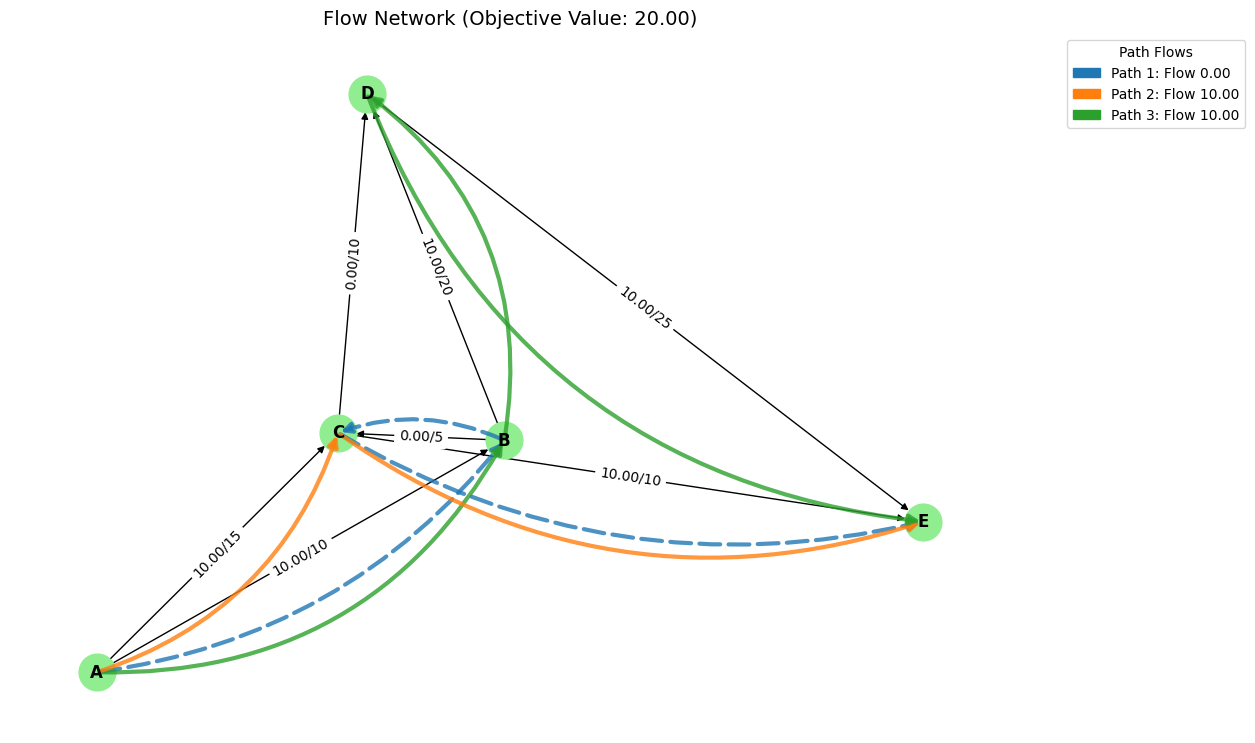

[[1 0 1 0]
 [0 1 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 1 0 0]
 [0 0 1 1]]
==================iter [ 4 ]======================
xp =  [0.0, 10.0, 10.0, 5.0]
obj_fct_val =  25.0
[N.4 RLPM problem] :
['xp1', 'xp2', 'xp3', 'xp4']
max xp1 + xp2 + xp3 + xp4
st1 : xp1*1.0 + xp3*1.0 <= 10.0
st2 : xp2*1.0 + xp4*1.0 <= 15.0
st3 : xp1*1.0 <= 5.0
st4 : xp3*1.0 <= 20.0
st5 : xp4*1.0 <= 10.0
st6 : xp1*1.0 + xp2*1.0 <= 10.0
st7 : xp3*1.0 + xp4*1.0 <= 25.0
-----------------------------------------------
xp =  [0.0, 10.0, 10.0, 5.0]
max(xp1 + xp2 + xp3 + xp4) =  25.0
-----------------------------------------------
pi =  [9.99998e-01 9.99998e-01 1.00000e-06 1.00000e-06 1.00000e-06 2.00000e-06
 1.00000e-06]
p_new_binary =  [0, 1, 0, 0, 0, 1, 0]
reduced cost = 1 - <pi, p_new> =  0.0
！！！！！！！！！！！！： 4
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
xp[3]:  5.0
！！！！！！！！！！！！： 4
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
xp[3]:  5.0
！！！！！！！！！！！！： 4
xp[0]:  0.0
xp[1]:  10.0
xp[2]:  10.0
xp[3]:  5.0
！！！！！！！！！！！！： 4
xp[0]:  0.

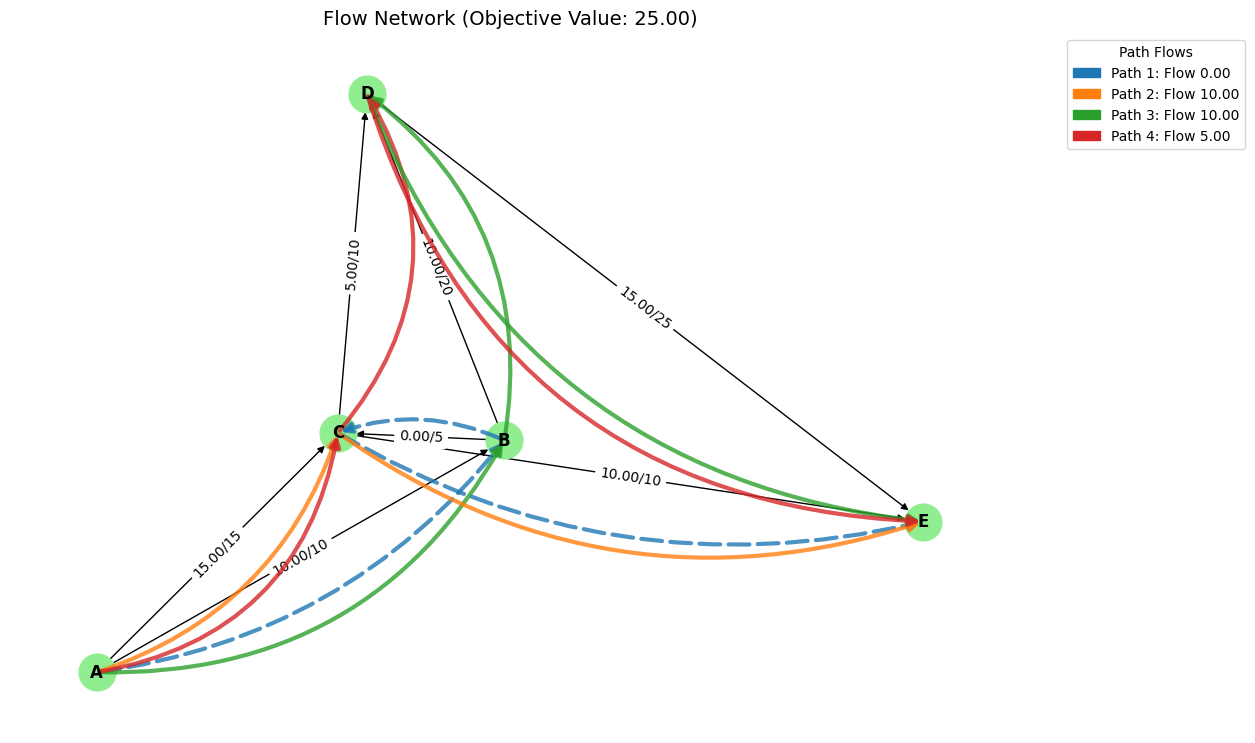

Final Pattern Matrix:
[[1 0 1 0]
 [0 1 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 1 0 0]
 [0 0 1 1]]
Final Solution:
[ 0. 10. 10.  5.]
Final Objective Value:
25.0


In [126]:
import numpy as np

V = ['A', 'B', 'C', 'D', 'E']
E = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E')]


# 初始路径集合的 0-1 矩阵
# Pd = [
#     [1, 1, 0, 0, 0, 1, 0],  # A -> B
#     [0, 0, 1, 0, 1, 0, 1],  # A -> C
#     [1, 0, 0, 0, 0, 0, 1],  # B -> C
#     [0, 1, 0, 0, 0, 0, 0],  # B -> D
#     [0, 0, 1, 0, 0, 0, 0],  # C -> D
#     [1, 1, 1, 1, 1, 0, 0],  # C -> E
#     [0, 1, 1, 1, 1, 1, 1],  # D -> E
# ]

Pd = [
    [1],  # A -> B
    [0],  # A -> C
    [1],  # B -> C
    [0],  # B -> D
    [0],  # C -> D
    [1],  # C -> E
    [0],  # D -> E
]


d = ['A', 'E']

Cap_E = [10,
         15,
         5,
         20,
         10,
         10,
         25
]



Pd0 = np.array(Pd)


Pd, final_solution, final_obj_value = column_generation(d, V, E, Cap_E, Pd0)

print("===============================================================")
print("Final Pattern Matrix:")
print(Pd)

print("Final Solution:")
print(final_solution)

print("Final Objective Value:")
print(final_obj_value)

In [ ]:
def print_result(iter, rlpm_cplex_obj ,rlpm_value, rlpm_solution, pi, p_new_binary, k):

  print("==================================================")
  # 1st RLPM problem
  print(f"[N.{iter} RLPM problem] :")
  # 打印objective function
  var_names = rlpm_cplex_obj.variables.get_names()
  print(var_names)
  obj_fct = " + ".join(
      [f"{var_names[i]}" for i in range(len(var_names))]
  )
  print(f"max {obj_fct}")
  # 打印全部约束的表达式，用正常人可读的方式，比如x1 + x2 + x3 >= 30
  for i in range(rlpm_cplex_obj.linear_constraints.get_num()):
      row = rlpm_cplex_obj.linear_constraints.get_rows(i)
      indices, values = row.unpack()
      constraint_str = " + ".join(
          [f"{rlpm_cplex_obj.variables.get_names(index)}*{value}" for index, value in zip(indices, values)]
      )
      rhs = rlpm_cplex_obj.linear_constraints.get_rhs(i)
      print(f"st{i+1} : {constraint_str} <= {rhs}")

  print("-----------------------------------------------")
  # print the current value of the variables
  print("xp = ", rlpm_solution)

  # print the current value of the objective function
  print(f"max({obj_fct}) = ", rlpm_value)

  print("-----------------------------------------------")

  # print the dual solution
  print("pi = ", pi)

  # print the solution of the 1st auxiliary sub-problem
  print("p_new_binary = ", p_new_binary)

  # print the reduced cost
  print("reduced cost = 1 - <pi, p_new> = ", k)

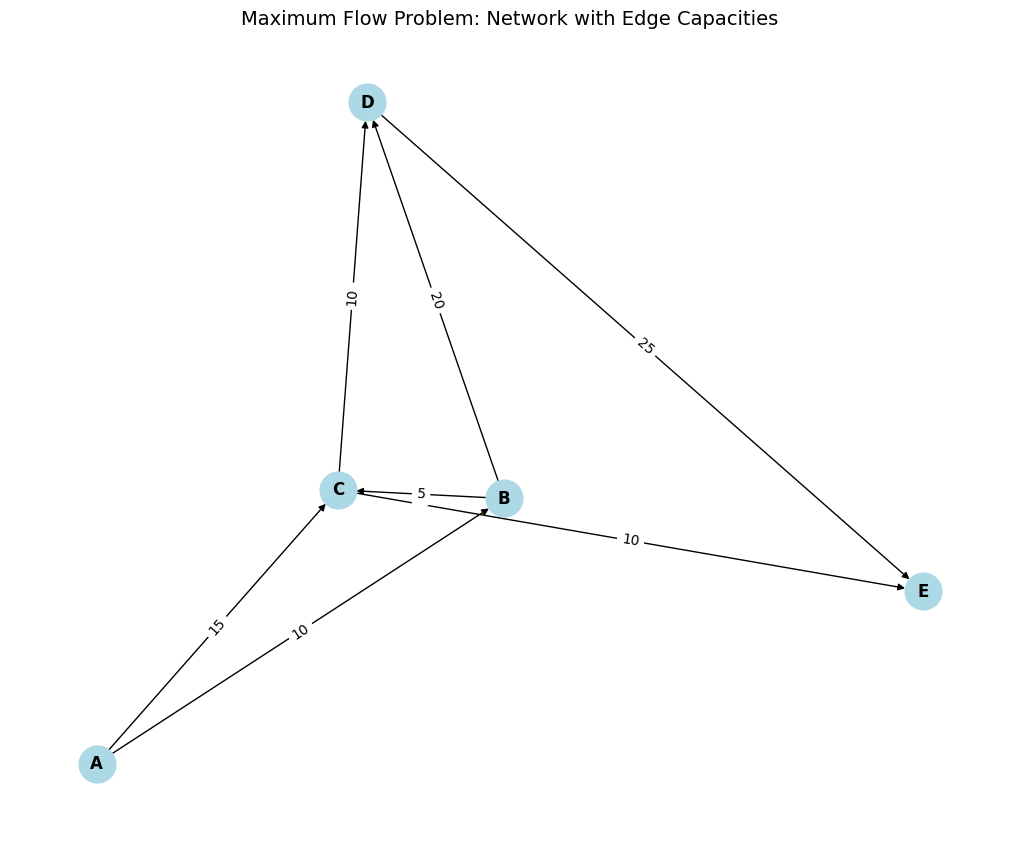

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Nodes and Edges
V = ['A', 'B', 'C', 'D', 'E']
E = [('A', 'B'), ('A', 'C'), ('B', 'C'), ('B', 'D'), ('C', 'D'), ('C', 'E'), ('D', 'E')]

# Edge Capacities
Cap_E = [10, 15, 5, 20, 10, 10, 25]

# Create a directed graph
G = nx.DiGraph()
G.add_nodes_from(V)
for edge, cap in zip(E, Cap_E):
    G.add_edge(edge[0], edge[1], capacity=cap)

# Position nodes using a layout
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=12, font_weight='bold')
edge_labels = {(u, v): f"{d['capacity']}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Maximum Flow Problem: Network with Edge Capacities", fontsize=14)
plt.show()


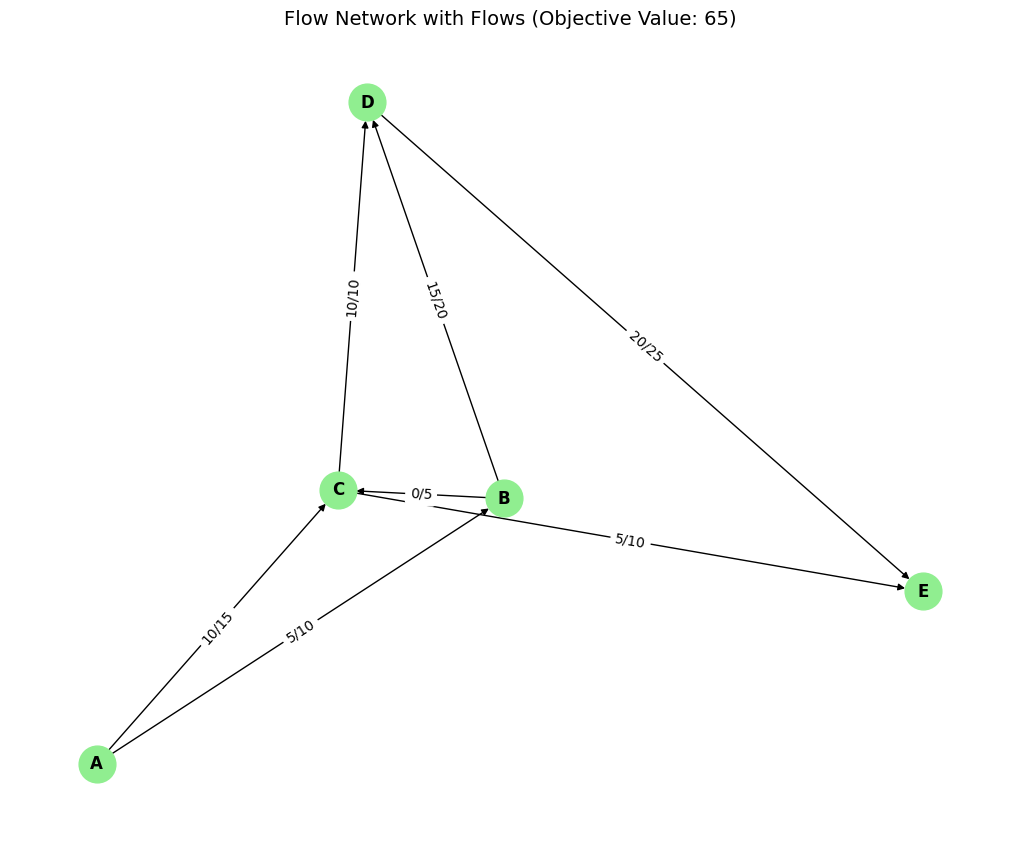